In [10]:
!pip install -U python-telegram-bot
# !pip freeze > requirements.txt
!pip install -U finance-datareader
!pip install schedule
!pip install bs4
!pip install datetime
!pip install pytz

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 514.6/514.6 kB 1.3 MB/s eta 0:00:00m eta 0:00:010:01:01
  Attempting uninstall: python-telegram-bot
    Found existing installation: python-telegram-bot 13.13
    Uninstalling python-telegram-bot-13.13:
      Successfully uninstalled python-telegram-bot-13.13


# 텔레그램 설정

In [2]:
import telegram
API_KEY = '5569257444:AAGV21Ds4fkrxhXkrevkdvQ289vGVcajYTU'
bot = telegram.Bot(token=API_KEY)

In [3]:
updates = bot.get_updates()
updates

In [5]:
bot.sendMessage(chat_id='1760120639', text='구른다')

In [40]:
# 필요한 라이브러리 설치 및 불러오기
import FinanceDataReader as fdr
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import datetime
from datetime import date
import sys
print(fdr.__version__)
import schedule
import time
import pytz
from numpyencoder import NumpyEncoder
import json
import telegram

0.9.42


# 차트 그리기

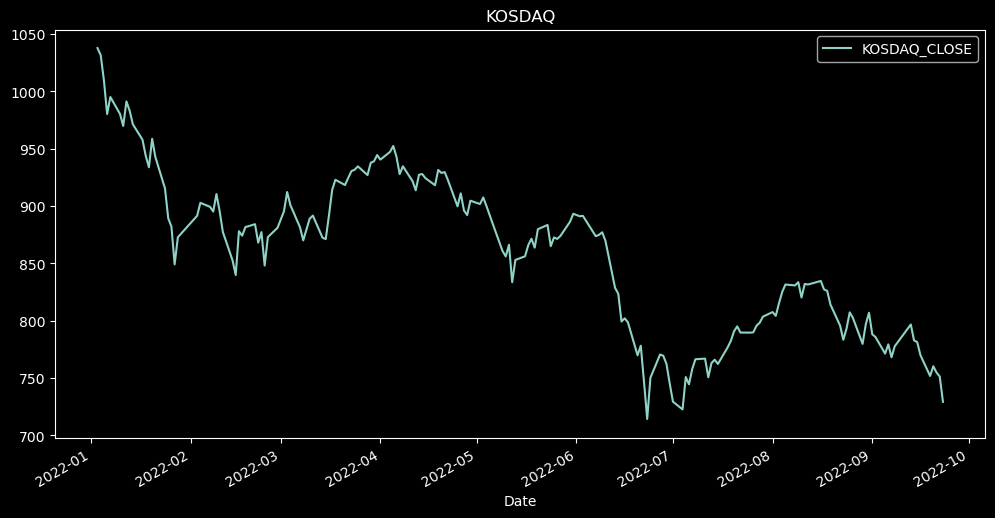

In [6]:
plt.style.use(['dark_background']) # 다크모드에서 보기
plt.title('KOSDAQ')
df = fdr.DataReader('KQ11', '2022')
df['Close'].plot(figsize=(12,6), label='KOSDAQ_CLOSE')
plt.legend()
plt.show()

# df = fdr.DataReader('AAPL',)
# df['Close'].plot(figsize=(12,6), label='AAPL')
# plt.legend()
# plt.show()

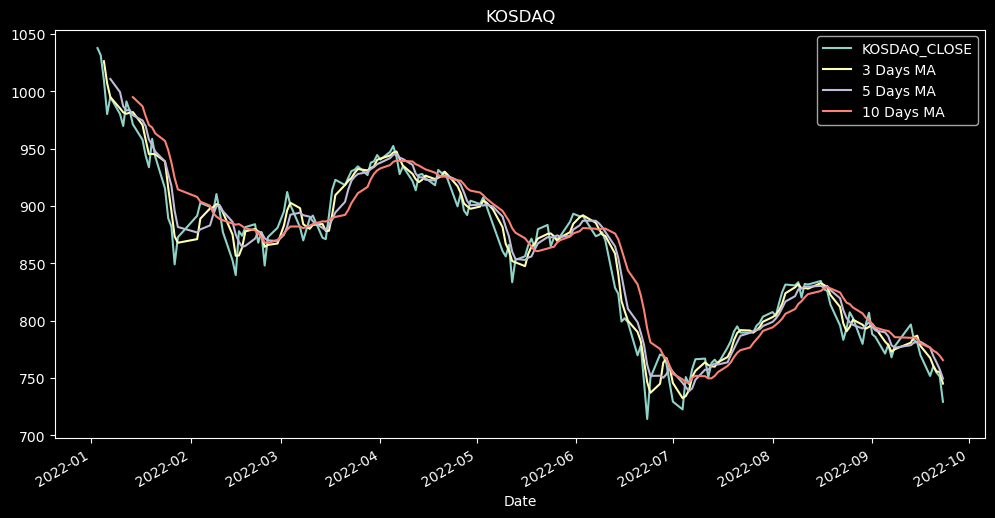

In [7]:
# 3,5,10 단순이동평균
plt.title('KOSDAQ')
df['Close'].plot(figsize=(12,6), label='KOSDAQ_CLOSE')
df['Close'].rolling(3).mean().plot(label = '3 Days MA')
df['Close'].rolling(5).mean().plot(label = '5 Days MA')
df['Close'].rolling(10).mean().plot(label = '10 Days MA')
plt.legend()
plt.show()

# 데이터셋 설정하기

In [8]:
code = 'KQ11'
df = fdr.DataReader('KQ11','2022-08').reset_index()
# 3,5,10 이동평균 딕셔너리에 할당
df['close_sma3d'] = df['Close'].rolling(3).mean()
df['close_sma5d'] = df['Close'].rolling(5).mean()
df['close_sma10d'] = df['Close'].rolling(10).mean()


In [9]:
# 최근 10일자 데이터만 불러오기
df.iloc[-10:]

,Date,Close,Open,High,Low,Volume,Change,close_sma3d,close_sma5d,close_sma10d
27,2022-09-08,777.81,776.59,781.52,775.31,738190000.0,0.0125,775.153333,776.554,785.749
28,2022-09-13,796.79,790.89,796.83,790.83,842460000.0,0.0244,780.930000,778.736,785.183
29,2022-09-14,782.93,775.93,784.45,770.05,858080000.0,-0.0174,785.843333,781.036,785.487
30,2022-09-15,781.38,786.33,787.00,780.31,851720000.0,-0.0020,787.033333,781.420,783.923
31,2022-09-16,770.04,776.49,780.25,768.70,889030000.0,-0.0145,778.116667,781.790,780.223
32,2022-09-19,751.91,771.52,772.45,750.64,882640000.0,-0.0235,767.776667,776.610,776.582
33,2022-09-20,760.35,758.35,764.40,757.33,804840000.0,0.0112,760.766667,769.322,774.029
34,2022-09-21,754.89,757.13,761.35,750.14,941670000.0,-0.0072,755.716667,763.714,772.375
35,2022-09-22,751.41,746.82,751.58,736.11,978690000.0,-0.0046,755.550000,757.720,769.570
36,2022-09-23,729.36,749.87,749.87,728.29,883280000.0,-0.0293,745.220000,749.584,765.687


In [10]:
# dataframe 재구성
df2 = df.loc[: ,['Date','Close', 'close_sma3d','close_sma5d','close_sma10d']].iloc[-1:]
df2.dtypes

Date            datetime64[ns]
Close                  float64
close_sma3d            float64
close_sma5d            float64
close_sma10d           float64
dtype: object

# 개인 봇으로 출력 테스트

In [12]:
# print('\n--- Close for 2022-08-01 ---\n')

# print(df.loc[ df['Date'] == '2022-08-01', 'Close'])

# print('\n--- Previous Close < Close ---\n')

# df['Previous Close'] = df['Close'].shift(1)
# # df['Previous Date']  = df['Date'].shift(1)

# lower_close = df[ df['Previous Close'] < df['Close'] ]
# print(lower_close[['Previous Close', 'Close', 'Date']])

# print('\n--- alert_three,five,ten_days ---\n')

# 3, 5, 10 마켓타이밍 유무 딕셔너리에 할당
alerts = df2[(df2['Close'] < df2['close_sma3d']) | (df2['Close'] < df2['close_sma5d']) | (df2['Close'] < df2['close_sma10d'])]

# def display(row):
#     row = row.to_json(orient='records')
#     print(f" - {row['Date']} Signal 발생! now_price list {row['Close']} 3일이동평균 {row['close_sma3d']}")
# Market_timing = alerts.apply(display, axis=1)

# bot.sendMessage(chat_id = '1760120639', text = Market_timing)

# 3, 5, 10 마켓타이밍시 코스닥 현재가와 이동평균가 출력
for index, row in alerts.iterrows():
    z = row['Close']
    a = round(row['close_sma3d'], 2)
    b = round(row['close_sma5d'], 2)
    c = round(row['close_sma10d'], 2)
    # telegram 알람에서 출력하기 위해 json으로 변환
    row['Date'] = row['Date'].date()
#     print(row['Date'])
    jsonstr1 = json.dumps(str(row['Date']))
    Market_timing = (f"{jsonstr1} 현재가가 3 or 5 or 10 단순이동평균보다 낮습니다 \n 코스닥_현재가 {z} \n 3일이동평균 {a} \n 5일이동평균 {b} \n 10일이동평균 {c}")
#     print(f" - {row['Date']} Signal 발생! 코스닥_현재가 {row['Close']} 3일이동평균 {row['close_sma3d']:.2f} 5일이동평균 {row['close_sma5d']:.2f} 10일이동평균 {row['close_sma10d']:.2f}")

API_KEY = '5569257444:AAGV21Ds4fkrxhXkrevkdvQ289vGVcajYTU'
bot = telegram.Bot(token=API_KEY)
bot.sendMessage(chat_id = '1760120639', text = Market_timing)


# MarketTimer_1.0.py

In [ ]:
#!/usr/bin/env python
# coding: utf-8

# In[ ]:

import FinanceDataReader as fdr
import matplotlib.pyplot as plt
# get_ipython().run_line_magic('matplotlib', 'inline')
import numpy as np
import pandas as pd
import datetime
from datetime import date
import sys
fdr.__version__
import schedule
import time
import pytz
from numpyencoder import NumpyEncoder
import telegram
import json


# count = 1

def job():
    # 전역변수 설정
#     global Market_timing
#     global count
#     count += 1
    # 한국시각, 주말 설정
#     now = datetime.datetime.now(pytz.timezone('Asia/Seoul'))
    today = date.today()
    weekend = today.weekday()
    # 예외시간 설정. 9시 이전 및 15시 이후, 주말에는 알람을 보내지 않음
    while weekend >= 5:
        return None
    
    # 봇 설정
    API_KEY = '5569257444:AAGV21Ds4fkrxhXkrevkdvQ289vGVcajYTU'
    bot = telegram.Bot(token=API_KEY)
    bot.get_updates()
    public_chat_name = '@MarketTimer_alarm_bot'
    
    # 코스닥지수
    code = 'KQ11'
    df = fdr.DataReader('KQ11','2022-08').reset_index()
    # 3,5,10 이동평균 딕셔너리에 할당
    df['close_sma3d'] = df['Close'].rolling(3).mean()
    df['close_sma5d'] = df['Close'].rolling(5).mean()
    df['close_sma10d'] = df['Close'].rolling(10).mean()
    # dataframe 재구성
    df2 = df.loc[: ,['Date','Close', 'close_sma3d','close_sma5d','close_sma10d']].iloc[-1:]
    alerts = df2[(df2['Close'] > df2['close_sma3d']) | (df2['Close'] > df2['close_sma5d']) | (df2['Close'] > df2['close_sma10d'])]
    alerts2 = df2[(df2['Close'] < df2['close_sma3d']) & (df2['Close'] < df2['close_sma5d']) & (df2['Close'] < df2['close_sma10d'])]
#     def display(row):
# #         row.to_json(orient='records')
#         print(f" - {row['Date']} Signal 발생! 코스닥_현재가 {row['Close']} 3일이동평균 {row['close_sma3d']:.2f} 5일이동평균 {row['close_sma5d']:.2f} 10일이동평균 {row['close_sma10d']:.2f}")
#     Market_timing = alerts.apply(display, axis=1)
    for index, row in alerts.iterrows():
        z = row['Close']
        a = round(row['close_sma3d'], 2)
        b = round(row['close_sma5d'], 2)
        c = round(row['close_sma10d'], 2)
    # telegram 알람에서 출력하기 위해 datetime64만 json str 형식으로 변환
        row['Date'] = row['Date'].date()
        jsonstr1 = json.dumps(str(row['Date']))
        Market_timing = (f"{jsonstr1} 현재가가 3 or 5 or 10 단순이동평균보다 높습니다\n 코스닥_현재가 {z}\n 3일이동평균 {a}\n 5일이동평균 {b}\n 10일이동평균 {c}")
        bot.sendMessage(chat_id = public_chat_name, text=Market_timing).chat_id
#             bot.sendMessage(chat_id = '1760120639', text = Market_timing)
    for index, row in alerts2.iterrows():
        z2 = row['Close']
        a2 = round(row['close_sma3d'], 2)
        b2 = round(row['close_sma5d'], 2)
        c2 = round(row['close_sma10d'], 2)
    # telegram 알람에서 출력하기 위해 datetime64만 json str 형식으로 변환
        row['Date'] = row['Date'].date()
        jsonstr2 = json.dumps(str(row['Date']))
        Market_timing2 = (f"{jsonstr2} 현재가가 3 and 5 and 10 단순이동평균보다 낮습니다\n 코스닥_현재가 {z2}\n 3일이동평균 {a2}\n 5일이동평균 {b2}\n 10일이동평균 {c2}")
        bot.sendMessage(chat_id = public_chat_name, text=Market_timing2).chat_id

# 특정 시간에 실행하기
schedule.every().day.at("09:00").do(job)
schedule.every().day.at("10:00").do(job)
schedule.every().day.at("12:00").do(job)
schedule.every().day.at("14:00").do(job)
schedule.every().day.at("15:30").do(job)

print('Start App..')

while True:
    schedule.run_pending()
    time.sleep(1)


Start App..
5


# 예외 처리

In [1]:
# exception handling
import schedule
import functools
import json
import datetime
from datetime import date
import time

def catch_exceptions(cancel_on_failure=False):
    def catch_exceptions_decorator(job_func):
        @functools.wraps(job_func)
        def wrapper(*args, **kwargs):
            try:
                return job_func(*args, **kwargs)
            except:
                import traceback
                print(traceback.format_exc())
                if cancel_on_failure:
                    return schedule.CancelJob
        return wrapper
    return catch_exceptions_decorator

@catch_exceptions(cancel_on_failure=True)
def bad_task():
    return 1 / 0

schedule.every(5).minutes.do(bad_task)

Every 5 minutes do bad_task() (last run: [never], next run: 2022-09-08 20:37:26)

# Dart-Fss 사용하여 공시보고서 검색

In [17]:
!pip install dart-fss

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.8/126.8 kB 1.0 MB/s eta 0:00:001.8 MB/s eta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.2/112.2 kB 655.4 kB/s eta 0:00:003.5 MB/s eta 0:00:01
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 kB 78.1 kB/s eta 0:00:000:00:0136m0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 1.1 MB/s eta 0:00:00m eta 0:00:010:01:010m
  Preparing metadata (setup.py) ... done
  Created wheel for arelle: filename=arelle-2.2-py3-none-any.whl size=2060308 sha256=b9fb43089d280add51a6f607af5cbe980cf82c79d44582a53f2aac62cff255d6
  Stored in directory: /Users/jaeuk/Library/Caches/pip/wheels/ae/ea/80/69a7c9134cb71ed0d6d427cbba1918e8a20be166b616558bd1
  Created wheel for fake-useragent: filename=fake_useragent-0.1.11-py3-none-any.whl size=13502 sha256=748f07208118475115ad4b4e98179f762dd07bff53e57299ad3f9bbe589cc98d
  Stored in directory: /Users/jaeuk/Li

In [46]:
import dart_fss as dart


# Open API KEY 설정
api_key = '8dd454087d3a1dc701f2b537306504c267ba2a5d'
dart.set_api_key(api_key=api_key)

# DART 에 공시된 회사 리스트 불러오기
corp_list = dart.get_corp_list()

# 기업 고유 번호 불러오기
dart.utils.request.get('https://opendart.fss.or.kr/api/corpCode.xml', api_key)

<Response [200]>